In [1]:
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np
from numpy.linalg import inv
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MeanSquaredError

In [2]:
size = 512
channels = 1  #input image format
input_img = Input(shape=(size, size, channels))

def preprocess_image(image):
    #resize image so they're same format
    image = tf.image.resize(image, (size, size), method='lanczos5')
    return image

datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_image,
    validation_split=0.2
)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Rotates the images by up to 10 degrees
    width_shift_range=0.1,  # Shifts the image width by a maximum of 10%
    height_shift_range=0.1,  # Shifts the image height by a maximum of 10%
    shear_range=0.1,  # Shear angle in counter-clockwise direction
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels
    preprocessing_function=preprocess_image,
    validation_split=0.2
)

In [3]:
#load trained model
autoencoder = load_model('0505x1x3.keras')
#autoencoder = load_model('0504_5.keras')



In [4]:
anomalous_generator = datagen.flow_from_directory(
    'finalTestingAnomalous',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    shuffle = False
)

Found 433 images belonging to 6 classes.


In [5]:
normal_generator = datagen.flow_from_directory(
    'finaltestingNormal',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    shuffle = False
)

Found 78 images belonging to 3 classes.


In [6]:
train_generator = datagen.flow_from_directory(
    'thesis/dataset',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=8,
    class_mode='input',
    shuffle = False
)

Found 85 images belonging to 5 classes.


In [6]:
#test model
predicted_anomalous = autoencoder.predict(anomalous_generator, steps=len(anomalous_generator))


/Users/yong/anaconda3/envs/plard/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


In [7]:
predicted_normal = autoencoder.predict(normal_generator, steps=len(normal_generator))

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


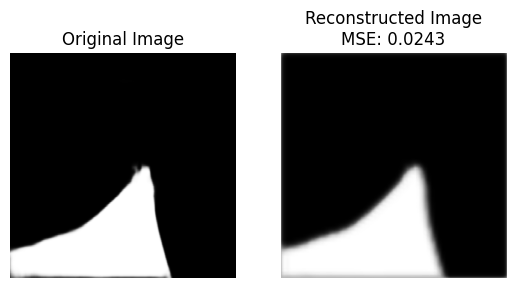

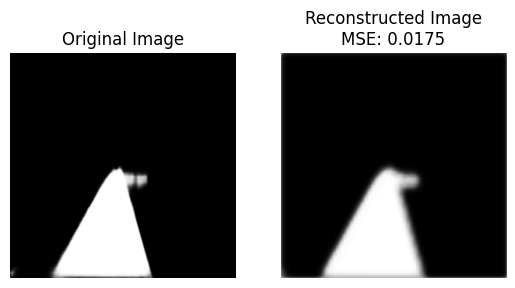

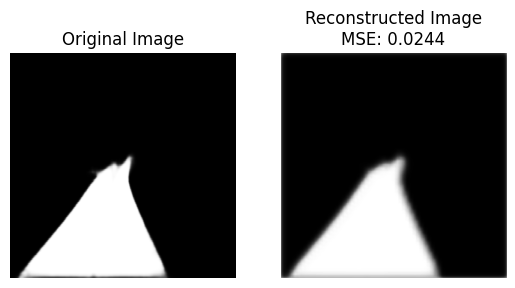

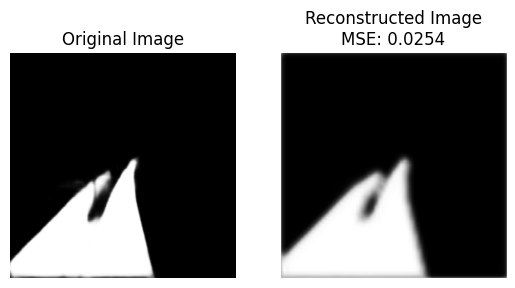

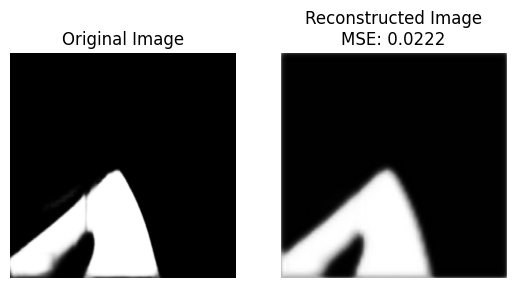

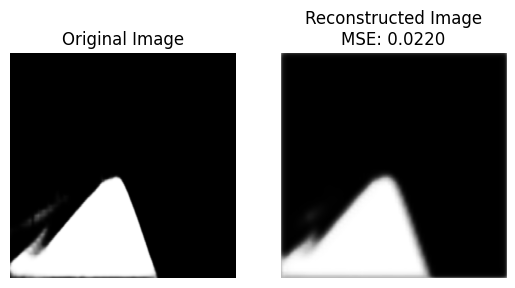

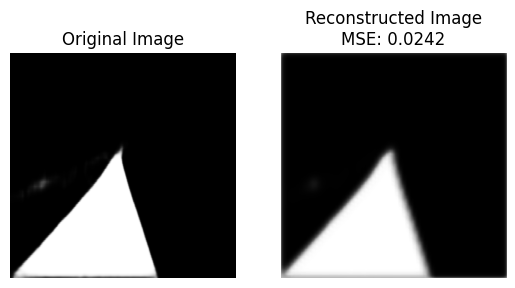

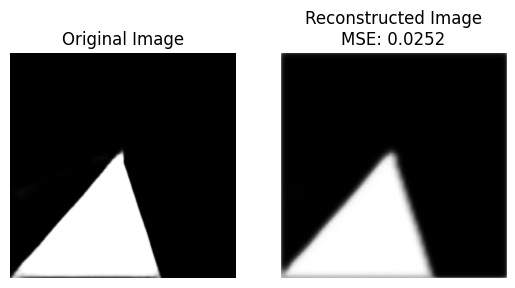

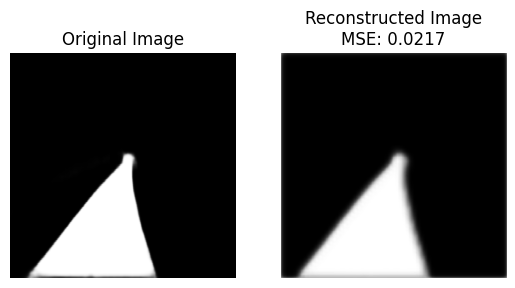

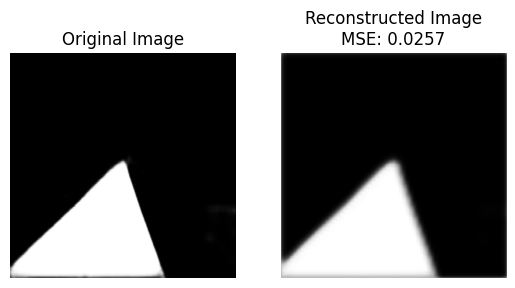

In [8]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean((original - reconstruction) ** 2)

#visualize first N images
N = 10

#reset generator
normal_generator.reset()

count = 0
for original_batch, _ in normal_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        predicted_img = predicted_normal[count]

        #calculate the MSE loss
        loss = mse_loss(original_img, predicted_img)

        #plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        #plot predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_img.squeeze(), cmap='gray')
        plt.title(f'Reconstructed Image\nMSE: {loss:.4f}')
        plt.axis('off')

        plt.show()

        count += 1
    if count >= N:
        break 

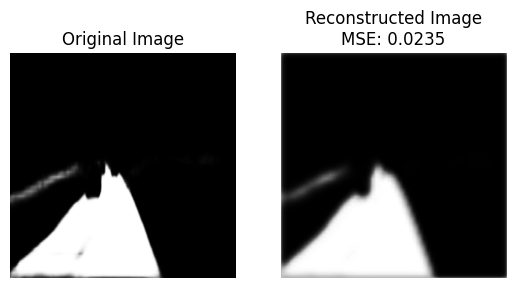

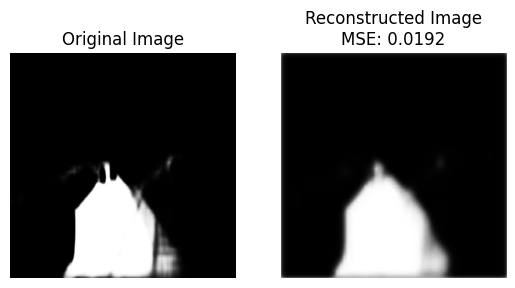

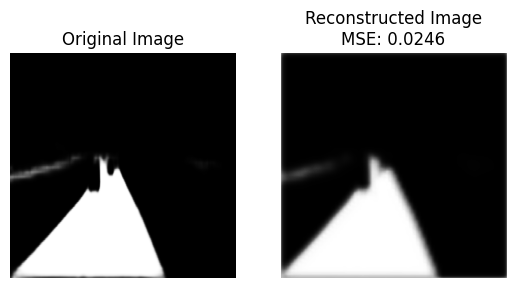

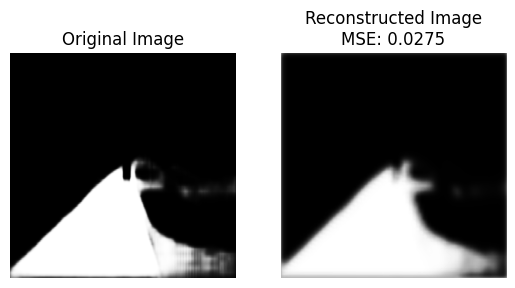

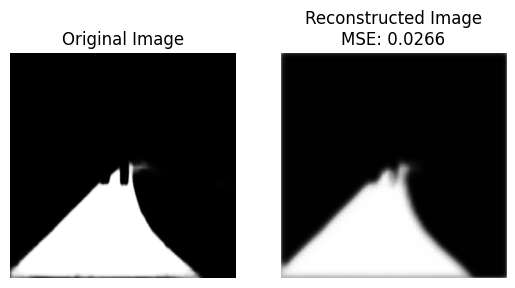

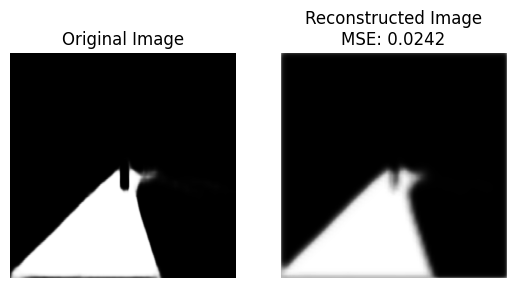

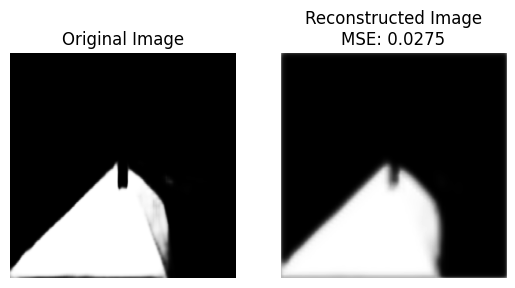

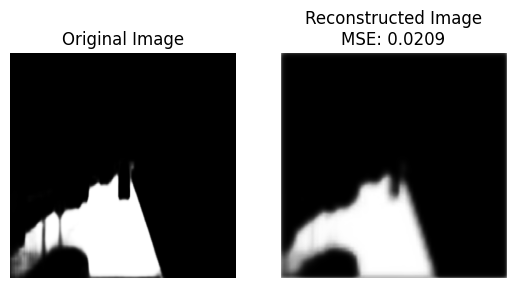

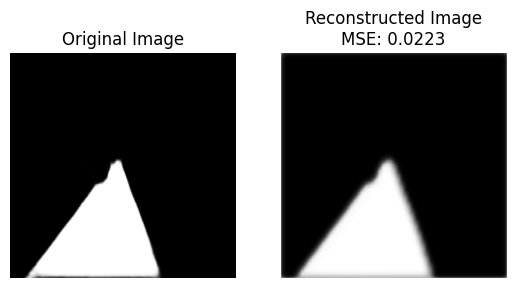

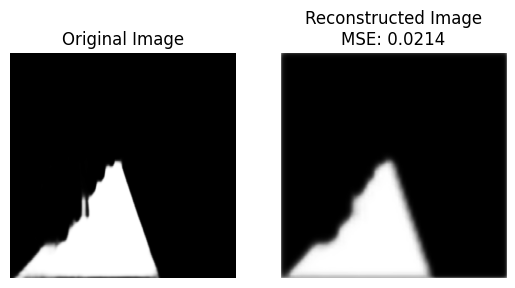

In [9]:
#function to calculate MSE
def mse_loss(original, reconstruction):
    return np.mean((original - reconstruction) ** 2)

#visualize first N images
N = 10

#reset generator
anomalous_generator.reset()

count = 0
for original_batch, _ in anomalous_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        predicted_img = predicted_anomalous[count]

        #calculate the MSE loss
        loss = mse_loss(original_img, predicted_img)

        #plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        #plot predicted image
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_img.squeeze(), cmap='gray')
        plt.title(f'Reconstructed Image\nMSE: {loss:.4f}')
        plt.axis('off')

        plt.show()

        count += 1
    if count >= N:
        break 

In [16]:
#calculate MSE
def mse_loss(original, reconstruction):
    return np.mean(np.square(original - reconstruction))

def calculate_mse_values(model, generator):
    # Calculate the number of steps required to process all images
    num_samples = generator.samples
    batch_size = generator.batch_size
    steps = (num_samples + batch_size - 1) // batch_size  # Ensure all samples are covered
    print(f"Total samples: {num_samples}, Batch size: {batch_size}, Steps: {steps}")

    # Get predictions for the test images
    predicted_images = model.predict(generator, steps=steps)

    # Ensure the generator is properly reset for consistent image fetching
    generator.reset()

    # Initialize MSE values array
    mse_values = []
    count = 0

    # Process each batch
    for original_batch, _ in generator:
        for j in range(original_batch.shape[0]):
            # Check to prevent index out-of-bound error
            if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

            original_img = original_batch[j]
            predicted_img = predicted_images[count]

            # Calculate MSE and store it
            loss = mse_loss(original_img, predicted_img)
            mse_values.append(loss)

            count += 1
        if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

    print(f"Processed {count} images.")
    return mse_values


Total samples: 433, Batch size: 32, Steps: 14
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Stopping early: reached end of predicted images at count 433
Processed 433 images.


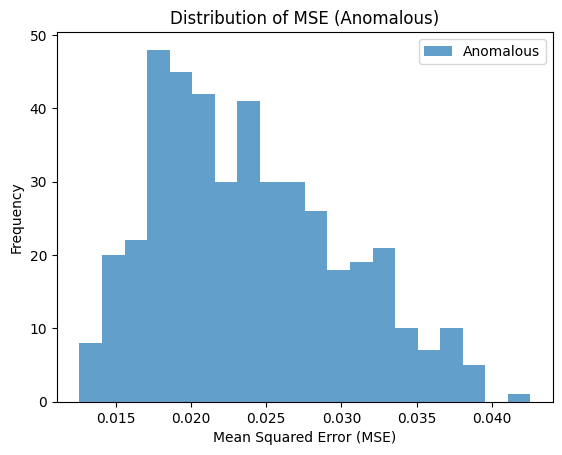

In [17]:
#anomalous MSE distribution plot 
anomalous = calculate_mse_values(autoencoder, anomalous_generator)
plt.hist(anomalous, bins=20, alpha=0.7, label='Anomalous')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Anomalous)')
plt.legend()

plt.show()

Total samples: 78, Batch size: 32, Steps: 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Stopping early: reached end of predicted images at count 78
Processed 78 images.


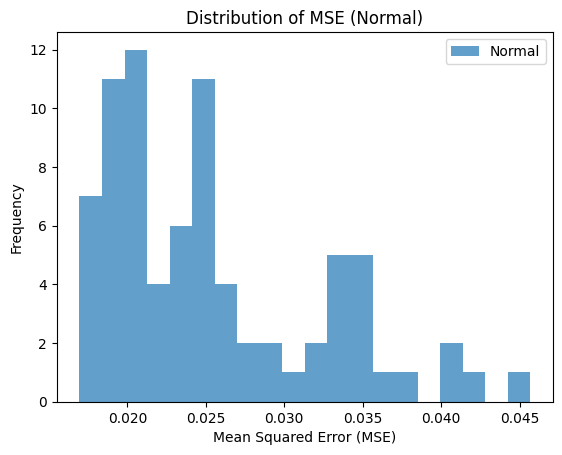

In [18]:
#normal MSE distribution plot 
normal = calculate_mse_values(autoencoder, normal_generator)
plt.hist(normal, bins=20, alpha=0.7, label='Normal')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Normal)')
plt.legend()

plt.show()

In [13]:
threshold = 0.1810

In [15]:
def analyze_mse_anomalous(mse_values, threshold):
    """
    Analyzes and plots the MSE values to show how many are on or below a given threshold.
    
    Args:
    mse_values (list or array): The MSE values.
    threshold (float): The threshold value for comparison.
    
    Returns:
    float: The percentage of MSE values on or below the threshold.
    """
    # Calculate the number of MSE values on or below the threshold
    above_threshold = [mse for mse in mse_values if mse > threshold]
    percentage_below = (len(above_threshold) / len(mse_values)) * 100
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=20, color='skyblue', alpha=0.7, label='MSE Values')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('MSE Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of MSE Values with Threshold')
    plt.legend()
    plt.show()
    
    return percentage_below

percentage = analyze_mse_anomalous(anomalous, threshold)
print(f"Percentage of MSE values above the threshold: {percentage:.2f}%")
print(len(anomalous))


NameError: name 'anomalous' is not defined

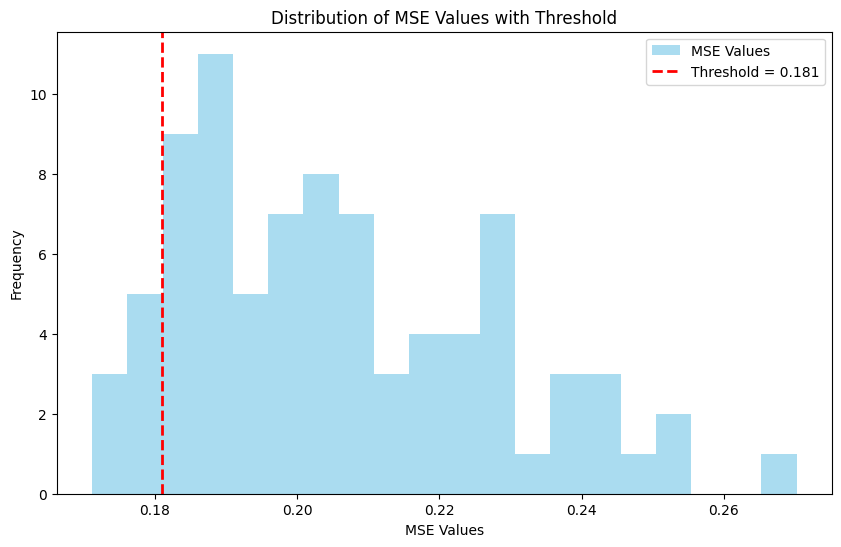

Percentage of MSE values on or below the threshold: 9.52%


In [15]:
def analyze_mse_normal(mse_values, threshold):
    """
    Analyzes and plots the MSE values to show how many are on or below a given threshold.
    
    Args:
    mse_values (list or array): The MSE values.
    threshold (float): The threshold value for comparison.
    
    Returns:
    float: The percentage of MSE values on or below the threshold.
    """
    # Calculate the number of MSE values on or below the threshold
    below_threshold = [mse for mse in mse_values if mse <= threshold]
    percentage_below = (len(below_threshold) / len(mse_values)) * 100
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.hist(mse_values, bins=20, color='skyblue', alpha=0.7, label='MSE Values')
    plt.axvline(x=threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold}')
    plt.xlabel('MSE Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of MSE Values with Threshold')
    plt.legend()
    plt.show()
    
    return percentage_below

percentage = analyze_mse_normal(normal, threshold)
print(f"Percentage of MSE values on or below the threshold: {percentage:.2f}%")


In [20]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import MeanSquaredError

# Initialize VGG19 model and feature extractor once
base_model = VGG19(include_top=False, input_shape=(512, 512, 3))
base_model.trainable = False
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)

def custom_loss(y_true, y_pred):
    mse = MeanSquaredError()
    # Ensure inputs are tensors and have the correct shape [height, width, 1]
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    # Add a channel dimension if it's missing and convert to RGB
    if y_true.shape[-1] != 3:
        y_true = tf.image.grayscale_to_rgb(tf.expand_dims(y_true, -1))
    if y_pred.shape[-1] != 3:
        y_pred = tf.image.grayscale_to_rgb(tf.expand_dims(y_pred, -1))

    # Add batch dimension
    y_true = tf.expand_dims(y_true, axis=0)
    y_pred = tf.expand_dims(y_pred, axis=0)
    
    reconstruction_error = mse(y_true, y_pred)
    
    true_features = feature_extractor(y_true)
    pred_features = feature_extractor(y_pred)
    feature_loss = mse(true_features, pred_features)
    
    # Return the combined loss
    return float(reconstruction_error + 0.1 * feature_loss)

def calculate_customloss_values(model, generator):
    num_samples = generator.samples
    batch_size = generator.batch_size
    steps = (num_samples + batch_size - 1) // batch_size  # Ensure all samples are covered
    print(f"Total samples: {num_samples}, Batch size: {batch_size}, Steps: {steps}")

    # Get predictions for the test images
    predicted_images = model.predict(generator, steps=steps)

    # Ensure the generator is properly reset for consistent image fetching
    generator.reset()

    mse_values = []
    count = 0

    # Process each batch
    for original_batch, _ in generator:
        for j in range(original_batch.shape[0]):
            if count >= len(predicted_images):
                print(f"Stopping early: reached end of predicted images at count {count}")
                break

            original_img = original_batch[j].squeeze()  # Ensure the image is in the correct shape
            predicted_img = predicted_images[count].squeeze()  # Ensure the image is in the correct shape

            # Calculate custom loss and store it
            loss = custom_loss(original_img, predicted_img)
            mse_values.append(loss)
            count += 1

        if count >= len(predicted_images):
            print(f"Stopping early: reached end of predicted images at count {count}")
            break

    print(f"Processed {count} images.")
    return mse_values


Total samples: 433, Batch size: 32, Steps: 14
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Stopping early: reached end of predicted images at count 433
Processed 433 images.


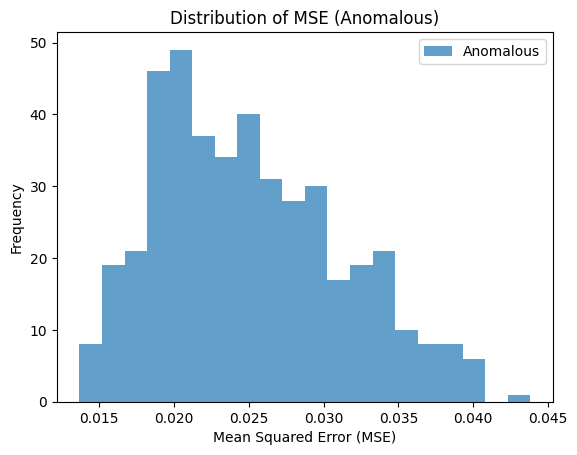

In [21]:
#anomalous MSE distribution plot 
anomalous = calculate_customloss_values(autoencoder, anomalous_generator)
plt.hist(anomalous, bins=20, alpha=0.7, label='Anomalous')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Anomalous)')
plt.legend()

plt.show()

Total samples: 78, Batch size: 32, Steps: 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Stopping early: reached end of predicted images at count 78
Processed 78 images.


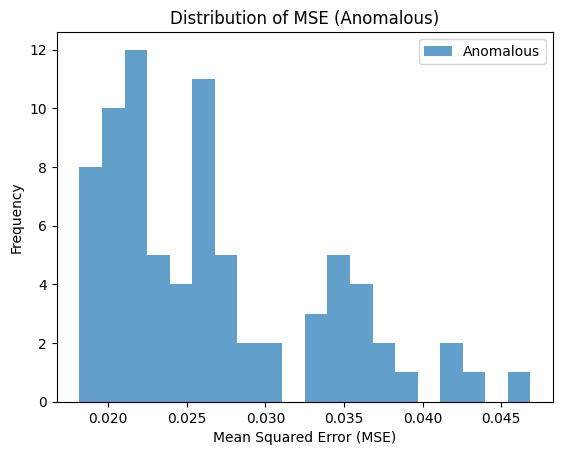

In [22]:
#anomalous MSE distribution plot 
normal = calculate_customloss_values(autoencoder, normal_generator)
plt.hist(normal, bins=20, alpha=0.7, label='Anomalous')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of MSE (Anomalous)')
plt.legend()

plt.show()